<a href="https://colab.research.google.com/github/Osama00112/CSE-372-ML-Project/blob/main/fusang_updated_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/ML\ project/Fusang/source_code/

 dl_model		  example_dl_output	        fusang.py  'public data'       simulation
 Environment_setting.md   example_msa		        LICENSE     README.md	       Train_data
 example_command.sh	 'Experimental phylogeny.zip'   logo.jpg    requirements.txt


In [ ]:
req_path = "/content/drive/MyDrive/ML project/Fusang/requirements.txt"


### Requirements install

In [ ]:
!pip install -r /content/drive/MyDrive/ML\ project/Fusang/requirements.txt

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.16.0rc0)
ERROR: No matching distribution found for tensorflow==2.3.1


In [ ]:
!pip install biopython
!pip install ete3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273785 sha256=8f1ecd265e878a19144081b84da38d7bc3320f4a215e33bcbc0f024431fa7dec
  Stored in directory: /root/.cache/pip/wheels/a0/72/00/1982bd848e52b03079dbf800900120bc1c20e92e9a1216e525
Successfully built ete3


### Imports

In [ ]:
import os
import re
import sys
import numpy as np
import functools
import argparse
from Bio import AlignIO
from itertools import combinations

import math
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential, regularizers

from ete3 import Tree
from pandas.core.frame import DataFrame

global org_seq, comb_of_id, dl_model, dl_predict, len_of_msa, dic_for_leave_node_comb_name, start_end_list
global taxa_num, leave_node_id, leave_node_name, leave_node_comb_id, leave_node_comb_name, internal_node_name_pool
global loss_list, X_train_ext, y_train_ext

from multiprocessing import Process, Pool
import multiprocessing

from tensorflow.keras import layers, optimizers
from tqdm import tqdm

### Util functions
- comb_math
- nlargest_indices
- get_quartet_ID

In [ ]:
def comb_math(n,m):
    return math.factorial(n)//(math.factorial(n-m)*math.factorial(m))


def nlargest_indices(arr, n):
    uniques = np.unique(arr)
    threshold = uniques[-n]
    return np.where(arr >= threshold)


def get_quartet_ID(quartet):
    return "".join(sorted(quartet))

### Tree from quartet

In [ ]:
def tree_from_quartet(quartet):
    root = Tree()
    root.name = "internal_node_0"
    left = root.add_child(name="internal_node_1")
    left.add_child(name=quartet[0])
    left.add_child(name=quartet[1])
    right = root.add_child(name="internal_node_2")
    right.add_child(name=quartet[2])
    right.add_child(name=quartet[3])
    for desc in root.iter_descendants():
        desc.dist = 0
    return root

### Getting topology ID
- Given a quartet
- Given a quartet key and 2 clusters

In [ ]:
def get_topology_ID(quartet):
    return get_quartet_ID(quartet[0:2]) + get_quartet_ID(quartet[2:4])


def get_current_topology_id(quart_key, cluster_1, cluster_2):
    ans = []
    a1 = quart_key.index(cluster_1)
    a2 = quart_key.index(cluster_2)
    ans.append(str(a1))
    ans.append(str(a2))
    ans = set(ans)
    if ans == {'0', '1'} or ans == {'2', '3'}:
        return 0
    elif ans == {'0', '2'} or ans == {'1', '3'}:
        return 1
    elif ans == {'0', '3'} or ans == {'1', '2'}:
        return 2
    else:
        print('Error of function get_current_topology_id, exit the program')
        sys.exit(0)

### Tree Functions
- judge_tree_score
- get_modify_tree

In [ ]:
def judge_tree_score(tree, quart_distribution, new_addition_taxa, dic_for_leave_node_comb_name):
    '''
        parameter
        tree: a candidate tree, can be any taxas
        quart_distribution: the prob distribution of the topology of every 4-taxa
    '''
    crt_tree = tree.copy("newick")
    leaves = crt_tree.get_leaves()

    leaves = [ele.name for ele in leaves]
    total_quarts = list(combinations(leaves, 4))
    quarts = []
    for ele in total_quarts:
        if new_addition_taxa in ele:
            quarts.append(ele)

    total_quart_score = 0

    for quart in quarts:
        crt_tree = tree.copy("newick")
        try:
            crt_tree.prune(list(quart))
        except:
            print('Error of pruning 4 taxa from current tree, the current tree is:')
            print(crt_tree)
            sys.exit(0)

        quart_key = "".join(sorted(list(quart)))
        #quart_topo_id = leave_node_comb_name.index(quart_key)

        quart_topo_id = dic_for_leave_node_comb_name[quart_key]

        quart_topo_distribution = quart_distribution[quart_topo_id]

        # judge current tree belongs to which topology
        tmp = re.findall("\([\s\S]\,[\s\S]\)", crt_tree.write(format=9))[0]
        topology_id = get_current_topology_id(quart_key, tmp[1], tmp[3])

        total_quart_score += np.log(quart_topo_distribution[topology_id]+1e-200)

    return total_quart_score


def get_modify_tree(tmp_tree, edge_0, edge_1, new_add_node_name):
    '''
        add a new leave node between edge_0 and edge_1
        default: edge_0 is the parent node of edge_1
    '''
    modify_tree = tmp_tree.copy("newick")
    if edge_0 != edge_1:
        new_node = Tree()
        new_node.add_child(name=new_add_node_name)
        detached_node = modify_tree&edge_1
        detached = detached_node.detach()
        inserted_node = modify_tree&edge_0
        inserted_node.add_child(new_node)
        new_node.add_child(detached_node)

    else:
        modify_tree.add_child(name=new_add_node_name)

    return modify_tree


### Search branch function

In [ ]:
def search_this_branch(tmp_tree, edge_0, edge_1, current_quartets, current_leave_node_name, queue, dic_for_leave_node_comb_name):
    modify_tree = get_modify_tree(tmp_tree, edge_0, edge_1, current_leave_node_name)
    modify_tree.resolve_polytomy(recursive=True)
    modify_tree.unroot()
    tmp_tree_score = judge_tree_score(modify_tree, current_quartets, current_leave_node_name, dic_for_leave_node_comb_name)

    dic = {}
    dic['tree'] = modify_tree
    dic['score'] = tmp_tree_score
    queue.put(dic)

### Mask Functions

In [ ]:
def select_mask_node_pair(dl_predict, new_add_taxa):

    if new_add_taxa <= 9:
        return None

    mask_node_pair = []

    current_start = start_end_list[new_add_taxa][0]
    current_end = start_end_list[new_add_taxa][1]
    select_distribution = dl_predict[current_start:current_end+1]
    if np.max(select_distribution) < 0.90:
        return None
    else:
        x,y = nlargest_indices(select_distribution, int(max(10,0.01*len(select_distribution))))

    for i in range(0,len(x)):
        idx = x[i]
        topology_value = y[i]
        quartet_comb = comb_of_id[current_start+idx]

        if topology_value == 0:
            mask_node_pair.append((quartet_comb[0],quartet_comb[1]))
        if topology_value == 1:
            mask_node_pair.append((quartet_comb[0],quartet_comb[2]))
        if topology_value == 2:
            mask_node_pair.append((quartet_comb[1],quartet_comb[2]))

    return mask_node_pair


def mask_edge(tree,node1,node2,edge_list):
    # mask edge between node1 and node2

    if len(edge_list) <= 3:
        return edge_list

    ancestor_name = tree.get_common_ancestor(node1,node2).name
    remove_edge = []

    node = tree.search_nodes(name=node1)[0]
    while node:
        if node.name == ancestor_name:
            break

        edge_0 = node.up.name
        edge_1 = node.name

        if len(remove_edge) >= len(edge_list) - 3:
            break
        remove_edge.append((edge_0, edge_1))
        node = node.up

    node = tree.search_nodes(name=node2)[0]
    while node:
        if node.name == ancestor_name:
            break

        edge_0 = node.up.name
        edge_1 = node.name

        if len(remove_edge) >= len(edge_list) - 3:
            break
        remove_edge.append((edge_0, edge_1))
        node = node.up

    for ele in remove_edge:
        if ele in edge_list:
            edge_list.remove(ele)

    return edge_list

### Gen_phylogen_tree
search phylo tree having highest score

In [ ]:
def gen_phylogenetic_tree(current_quartets, beam_size):
    '''
        search the phylogenetic tree having highest score
        idx: the name of numpy file
    '''
    current_leave_node_name = [chr(ord(u'\u4e00')+i) for i in range(0, taxa_num)]

    candidate_tree_beam = []

    quartet_id = leave_node_comb_name[0]

    for _label in [0, 1, 2]:
        if _label == 0:
            label_id = "".join([quartet_id[0], quartet_id[1], quartet_id[2], quartet_id[3]])
        elif _label == 1:
            label_id = "".join([quartet_id[0], quartet_id[2], quartet_id[1], quartet_id[3]])
        elif _label == 2:
            label_id = "".join([quartet_id[0], quartet_id[3], quartet_id[1], quartet_id[2]])

        _tree = tree_from_quartet(label_id)
        _tree.unroot()

        _tree_score = current_quartets[0, _label]

        tmp_tree_dict = {'Tree':_tree, 'tree_score':_tree_score}
        candidate_tree_beam.append(tmp_tree_dict)

        candidate_tree_beam.sort(key=lambda k: -k['tree_score'])

    idx_for_internal_node_name_pool = 0

    current_tree_score_beam = []
    optim_tree_beam = []

    #in the start point set beam size equal to 3
    for i in range(0, 3):
        current_tree_score_beam.append(candidate_tree_beam[i]['tree_score'])
        optim_tree_beam.append(candidate_tree_beam[i]['Tree'])

    for i in range(4, len(current_leave_node_name)):
        candidate_tree_beam = []

        for j in range(0, len(optim_tree_beam)):
            ele = optim_tree_beam[j]

            idx_for_this_iter = 0

            edge_0_list = []
            edge_1_list = []

            if ele == None:
                continue
            optim_tree = ele.copy("newick")

            for node in optim_tree.iter_descendants():
                tmp_tree = optim_tree.copy("newick")
                edge_0 = node.up.name
                edge_1 = node.name
                if edge_0 == '' or edge_1 == '':
                    continue

                else:
                    edge_0_list.append(edge_0)
                    edge_1_list.append(edge_1)

            queue = multiprocessing.Manager().Queue()
            para_list = [(tmp_tree, edge_0_list[k], edge_1_list[k], current_quartets, current_leave_node_name[i], queue, dic_for_leave_node_comb_name) for k in range(0, len(edge_0_list))]

            process_num = min(64, 2*i+6)
            pool = Pool(process_num)
            pool.starmap(search_this_branch, para_list)
            pool.close()
            pool.join()

            candidate_tree_score = []
            candidate_tree = []

            while not queue.empty():
                tmp_dic = queue.get()

                tmp_tree_dict = {'Tree':tmp_dic['tree'], 'tree_score':tmp_dic['score']+current_tree_score_beam[j]}
                candidate_tree_beam.append(tmp_tree_dict)

        candidate_tree_beam.sort(key=lambda k: -k['tree_score'])
        candidate_tree_beam = candidate_tree_beam[0:beam_size]

        optim_tree_beam = []
        current_tree_score_beam = []
        for ele in candidate_tree_beam:
            crt_tree = ele['Tree'].copy("newick")
            for node in crt_tree.traverse("preorder"):
                if node.name == '':
                    node.name = str(internal_node_name_pool[idx_for_internal_node_name_pool])
                    idx_for_internal_node_name_pool += 1
            optim_tree_beam.append(crt_tree)
            crt_tree_score = ele['tree_score']
            current_tree_score_beam.append(crt_tree_score)

    return optim_tree_beam[0].write(format=9)


def gen_phylogenetic_tree_2(current_quartets, beam_size):
    '''
        search the phylogenetic tree having highest score
        idx: the name of numpy file
    '''
    current_leave_node_name = [chr(ord(u'\u4e00')+i) for i in range(0, taxa_num)]

    candidate_tree_beam = []

    quartet_id = leave_node_comb_name[0]

    for _label in [0, 1, 2]:
        if _label == 0:
            label_id = "".join([quartet_id[0], quartet_id[1], quartet_id[2], quartet_id[3]])
        elif _label == 1:
            label_id = "".join([quartet_id[0], quartet_id[2], quartet_id[1], quartet_id[3]])
        elif _label == 2:
            label_id = "".join([quartet_id[0], quartet_id[3], quartet_id[1], quartet_id[2]])

        _tree = tree_from_quartet(label_id)
        _tree.unroot()

        _tree_score = current_quartets[0, _label]

        tmp_tree_dict = {'Tree':_tree, 'tree_score':_tree_score}
        candidate_tree_beam.append(tmp_tree_dict)

        candidate_tree_beam.sort(key=lambda k: -k['tree_score'])

    idx_for_internal_node_name_pool = 0

    current_tree_score_beam = []
    optim_tree_beam = []

    #in the start point set beam size equal to 3
    for i in range(0, 3):
        current_tree_score_beam.append(candidate_tree_beam[i]['tree_score'])
        optim_tree_beam.append(candidate_tree_beam[i]['Tree'])

    for i in range(4, len(current_leave_node_name)):
        candidate_tree_beam = []

        for j in range(0, len(optim_tree_beam)):
            ele = optim_tree_beam[j]

            idx_for_this_iter = 0

            edge_0_list = []
            edge_1_list = []

            if ele == None:
                continue
            optim_tree = ele.copy("newick")

            for node in optim_tree.iter_descendants():
                tmp_tree = optim_tree.copy("newick")
                edge_0 = node.up.name
                edge_1 = node.name
                if edge_0 == '' or edge_1 == '':
                    continue

                else:
                    edge_0_list.append(edge_0)
                    edge_1_list.append(edge_1)

            edge_list = [(edge_0_list[i], edge_1_list[i]) for i in range(0, len(edge_0_list))]
            mask_node_pairs = select_mask_node_pair(current_quartets, i)

            if mask_node_pairs != None:

                mask_node_pairs = list(set(mask_node_pairs))
                for node_pairs in mask_node_pairs:
                    node1 = chr(ord(u'\u4e00')+node_pairs[0])
                    node2 = chr(ord(u'\u4e00')+node_pairs[1])

                    edge_list = mask_edge(ele.copy("deepcopy"),node1,node2,edge_list)
                    if len(edge_list) <= 3:
                        break

            edge_0_list = [ele[0] for ele in edge_list]
            edge_1_list = [ele[1] for ele in edge_list]

            queue = multiprocessing.Manager().Queue()
            para_list = [(tmp_tree, edge_0_list[k], edge_1_list[k], current_quartets, current_leave_node_name[i], queue, dic_for_leave_node_comb_name) for k in range(0, len(edge_0_list))]

            process_num = min(64, len(edge_0_list))
            pool = Pool(process_num)
            pool.starmap(search_this_branch, para_list)
            pool.close()
            pool.join()

            candidate_tree_score = []
            candidate_tree = []

            while not queue.empty():
                tmp_dic = queue.get()

                tmp_tree_dict = {'Tree':tmp_dic['tree'], 'tree_score':tmp_dic['score']+current_tree_score_beam[j]}
                candidate_tree_beam.append(tmp_tree_dict)

        candidate_tree_beam.sort(key=lambda k: -k['tree_score'])
        candidate_tree_beam = candidate_tree_beam[0:beam_size]

        optim_tree_beam = []
        current_tree_score_beam = []
        for ele in candidate_tree_beam:
            crt_tree = ele['Tree'].copy("newick")
            for node in crt_tree.traverse("preorder"):
                if node.name == '':
                    node.name = str(internal_node_name_pool[idx_for_internal_node_name_pool])
                    idx_for_internal_node_name_pool += 1
            optim_tree_beam.append(crt_tree)
            crt_tree_score = ele['tree_score']
            current_tree_score_beam.append(crt_tree_score)

    return optim_tree_beam[0].write(format=9)

### Util functions
- transform_str
- cmp
- get_numpy

In [ ]:
def transform_str(str_a, taxa_name):
    str_b = ''
    id_set = [chr(ord(u'\u4e00')+i) for i in range(0, taxa_num)]

    for i in range(0, len(str_a)):
        if str_a[i] in id_set:
            str_b += taxa_name[ord(str_a[i])-ord(u'\u4e00')]
        else:
            str_b += str_a[i]

    return str_b


def cmp(a, b):
    if int(b) > int(a):
        return -1
    if int(a) < int(b):
        return 1
    return 0


def get_numpy(aln_file):
    '''
        current version only supports the total length of msa less than 10K
    '''
    aln = open(aln_file)
    dic = {'A':'0','T':'1','C':'2','G':'3','-':'4', 'N':'4'}

    # for masking other unknown bases
    other_base = ['R', 'Y', 'K', 'M', 'U', 'S', 'W', 'B', 'D', 'H', 'V', 'X']
    for ele in other_base:
        dic[ele] = '4'

    matrix_out=[]
    fasta_dic={}
    for line in aln:
        if line[0]==">":
            header=line[1:].rstrip('\n').strip()
            fasta_dic[header]=[]
        elif line[0].isalpha() or line[0]=='-':
            for base, num in dic.items():
                line=line[:].rstrip('\n').strip().replace(base,num)
            line=list(line)
            line=[int(n) for n in line]
            fasta_dic[header] += line+[4]*(14000-len(line))

    taxa_block=[]
    for taxa in sorted(list(fasta_dic.keys()), key=functools.cmp_to_key(cmp)):
        taxa_block.append(fasta_dic[taxa.strip()])
    fasta_dic={}
    matrix_out.append(taxa_block)

    return np.array(matrix_out)


# def gen_quartet_seq(str, id, start_point):
#     index = np.array(str)
#     end_point = start_point + 1200
#     current_quartet = org_seq[0,index[:],start_point:end_point]
#     quartet_seq[id, comb_of_id.index(str)] = current_quartet


# def gen_quartet_seq_2(str, id, start_point):
#     index = np.array(str)
#     end_point = start_point + 240
#     current_quartet = org_seq[0,index[:],start_point:end_point]
#     quartet_seq[id, comb_of_id.index(str)] = current_quartet

### Defining DL models for different lenghts (>1200 or >240)

In [ ]:
def get_resnext_dl_model_240():
    '''
    get the definition of dl model 240
    this model aims to solve the short length case
    which are length larger than 240
    '''
    conv_x=[4,1,1,1,1,1,1,1]
    conv_y=[1,2,2,2,2,2,2,2]
    pool=[1,2,2,2,2,2,2,2]
    filter_s=[1024,1024,128,128,128,128,128,128]
    visible = layers.Input(shape=(4,240,1))
    x = visible
    print(11111)

    # first 2 layers as it was
    for l in list(range(0,2)):
        x = layers.ZeroPadding2D(padding=((0, 0), (0,conv_y[l]-1)))(x)
        x = layers.Conv2D(filters=filter_s[l], kernel_size=(conv_x[l], conv_y[l]), strides=1, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(rate=0.2)(x)
        x = layers.AveragePooling2D(pool_size=(1,pool[l]))(x)

    print(x.shape)
    for _ in range(3):  # Loop 3 times for ResNeXt block
        # Split
        # print(x.shape[3]/32)
        div=x.shape[3]/32
        # div=4
        # splits = []

        # for i in range(32):  # Assuming 32 parallel channels
        #     split = layers.Lambda(lambda x: x[:, :, :, int(i*div):int((i+1)*div)])(x)
        #     splits.append(split)
        splits = tf.split(x, num_or_size_splits=32, axis=-1)
        print(splits[0].shape)

        # transforms = []
        j=0
        for split in splits:
            # Transform
            # transform = layers.ZeroPadding2D(padding=((0, 0), (0,1)))(split)
            transform = layers.Conv2D(filters=4, kernel_size=(1, 2), strides=1, activation='relu',padding='same')(split)
            transform = layers.BatchNormalization()(transform)
            transform = layers.Dropout(rate=0.2)(transform)
            transform = layers.AveragePooling2D(pool_size=(1, 2))(transform)

            # transform = layers.ZeroPadding2D(padding=((0, 0), (0,1)))(transform)
            transform = layers.Conv2D(filters=4, kernel_size=(1, 2), strides=1, activation='relu',padding='same')(transform)
            transform = layers.BatchNormalization()(transform)
            transform = layers.Dropout(rate=0.2)(transform)
            transform = layers.AveragePooling2D(pool_size=(1, 2))(transform)

            # transforms.append(transform)
            if j==0:
              transforms=transform
            else:
              transforms = layers.concatenate([transforms,transform], axis=-1)
            j+=1

        print('t ',transforms.shape)

        # Concatenate
        x_1 = layers.AveragePooling2D(pool_size=(1, 2))(x)
        x_1 = layers.AveragePooling2D(pool_size=(1, 2))(x_1)
        x_1 = layers.Conv2D(filters=128, kernel_size=(1, 1), strides=1, activation='relu')(x_1)
        print('x1 ',x_1.shape)
        # x_1 = layers.concatenate(transforms, axis=-1)
        x = layers.Add()([x_1, transforms])

    flat = layers.Flatten()(x)

    y = tf.keras.layers.Reshape((4,240))(visible)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True))(y)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True))(y)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(y)
    flat = tf.keras.layers.concatenate([flat, y],axis=-1)

    hidden1 = layers.Dense(1024,activation='relu')(flat)
    hidden1 = layers.Dense(32,activation='relu')(hidden1)
    drop1 = layers.Dropout(rate=0.2)(hidden1)
    output = layers.Dense(3, activation='softmax')(drop1)
    model = tf.keras.Model(inputs=visible, outputs=output)

    return model


def get_dl_model_1200():
    '''
    get the definition of dl model 1200
    this model aims to solve the default case
    which are length larger than 1200
    '''
    conv_x=[4,1,1,1,1,1,1,1]
    conv_y=[1,2,2,2,2,2,2,2]
    pool=[1,4,4,4,2,2,2,1]
    filter_s=[1024,1024,128,128,128,128,128,128]

    visible = layers.Input(shape=(4,1200,1))
    x = visible

    # skip_connections = []

    # # Initial convolutional layer
    # x = layers.Conv2D(filters=filter_s[0], kernel_size=(conv_x[0], conv_y[0]), strides=1, padding='same', activation='relu')(input_tensor)
    # x = layers.BatchNormalization()(x)
    # x = layers.Dropout(rate=0.2)(x)
    # x = layers.AveragePooling2D(pool_size=(1,pool[0]))(x)

    # # Append output of initial layer to skip connections list
    # skip_connections.append(x)


    for l in list(range(0,8)):
        x = layers.ZeroPadding2D(padding=((0, 0), (0,conv_y[l]-1)))(x)
        x = layers.Conv2D(filters=filter_s[l], kernel_size=(conv_x[l], conv_y[l]), strides=1, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(rate=0.2)(x)
        x = layers.AveragePooling2D(pool_size=(1,pool[l]))(x)

        # if i%2==1:
        #     if i==1:
        #         skip_connections.append(x)
        #     else:
        #         earlier_layer = skip_connections[-1]
        #         # Sum the current layer's output with earlier layer's output
        #         x = layers.add([x, earlier_layer])
        #         # Append current layer's output to skip connections
        #         skip_connections.append(x)
        # # if i % 2 == 1:
        # #     # Get the earlier layer from skip connections
        # #     earlier_layer = skip_connections[-1]
        # #     # Sum the current layer's output with earlier layer's output
        # #     x = layers.add([x, earlier_layer])
        # #     # Append current layer's output to skip connections
        # #     skip_connections.append(x)

    flat = layers.Flatten()(x)

    y = tf.keras.layers.Reshape((4,1200))(visible)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True))(y)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True))(y)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(y)
    flat = tf.keras.layers.concatenate([flat, y],axis=-1)

    hidden1 = layers.Dense(1024,activation='relu')(flat)
    drop1 = layers.Dropout(rate=0.2)(hidden1)
    output = layers.Dense(3, activation='softmax')(drop1)
    model = tf.keras.Model(inputs=visible, outputs=output)

    return model


def get_dl_model_240():
    '''
    get the definition of dl model 240
    this model aims to solve the short length case
    which are length larger than 240
    '''
    conv_x=[4,1,1,1,1,1,1,1]
    conv_y=[1,2,2,2,2,2,2,2]
    pool=[1,2,2,2,2,2,2,2]
    filter_s=[1024,1024,128,128,128,128,128,128]

    visible = layers.Input(shape=(4,240,1))
    x = visible

    for l in list(range(0,8)):
        x = layers.ZeroPadding2D(padding=((0, 0), (0,conv_y[l]-1)))(x)
        x = layers.Conv2D(filters=filter_s[l], kernel_size=(conv_x[l], conv_y[l]), strides=1, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(rate=0.2)(x)
        x = layers.AveragePooling2D(pool_size=(1,pool[l]))(x)

        #print(x.shape)

    flat = layers.Flatten()(x)

    y = tf.keras.layers.Reshape((4,240))(visible)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True))(y)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True))(y)
    y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(y)
    flat = tf.keras.layers.concatenate([flat, y],axis=-1)

    hidden1 = layers.Dense(1024,activation='relu')(flat)
    drop1 = layers.Dropout(rate=0.2)(hidden1)
    output = layers.Dense(3, activation='softmax')(drop1)
    model = tf.keras.Model(inputs=visible, outputs=output)

    return model



# def get_resnext_dl_model_240():
#     '''
#     get the definition of dl model 240
#     this model aims to solve the short length case
#     which are length larger than 240
#     '''
#     conv_x=[4,1,1,1,1,1,1,1]
#     conv_y=[1,2,2,2,2,2,2,2]
#     pool=[1,2,2,2,2,2,2,2]
#     filter_s=[1024,1024,128,128,128,128,128,128]
#     visible = layers.Input(shape=(4,240,1))
#     x = visible

#     # first 2 layers as it was
#     for l in list(range(0,2)):
#         x = layers.ZeroPadding2D(padding=((0, 0), (0,conv_y[l]-1)))(x)
#         x = layers.Conv2D(filters=filter_s[l], kernel_size=(conv_x[l], conv_y[l]), strides=1, activation='relu')(x)
#         x = layers.BatchNormalization()(x)
#         x = layers.Dropout(rate=0.2)(x)
#         x = layers.AveragePooling2D(pool_size=(1,pool[l]))(x)
#     for _ in range(3):  # Loop 3 times for ResNeXt block
#         # Split
#         splits = []
#         for i in range(32):  # Assuming 32 parallel channels
#             split = layers.Lambda(lambda x: x[:, :, :, i*4:(i+1)*4])(x)
#             splits.append(split)

#         transforms = []
#         for split in splits:
#             # Transform
#             transform = layers.Conv2D(filters=4, kernel_size=(1, 2), strides=1, activation='relu')(split)
#             transform = layers.BatchNormalization()(transform)
#             transform = layers.Dropout(rate=0.2)(transform)
#             transform = layers.AveragePooling2D(pool_size=(1, 2))(transform)
#             transforms.append(transform)

#         # Concatenate
#         x = layers.concatenate(transforms, axis=-1)

#     flat = layers.Flatten()(x)

#     y = tf.keras.layers.Reshape((4,240))(visible)
#     y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True))(y)
#     y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True))(y)
#     y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(y)
#     flat = tf.keras.layers.concatenate([flat, y],axis=-1)

#     hidden1 = layers.Dense(1024,activation='relu')(flat)
#     drop1 = layers.Dropout(rate=0.2)(hidden1)
#     output = layers.Dense(3, activation='softmax')(drop1)
#     model = tf.keras.Model(inputs=visible, outputs=output)

#     return model

### Predict Functions (slide_window)

In [ ]:
def fill_dl_predict_each_slide_window(len_idx_1, len_idx_2):
    start_pos = 0
    iters = len(comb_of_id) // 50000
    for i in range(0, iters):
        batch_seq = np.zeros((50000, 4, 1200))

        for j in range(0, len(batch_seq)):
            idx = np.array(comb_of_id[i*50000+j])
            batch_seq[j] = org_seq[0, idx[:], len_idx_1:len_idx_2]

        test_seq = tf.expand_dims(batch_seq.astype(np.float32), axis=-1)
        predicted = dl_model.predict(x=test_seq)

        for j in range(0, len(batch_seq)):
            dl_predict[i*50000+j,:] += predicted[j,:]
        #dl_predict[i*50000:i*50000+len(batch_seq),:] += predicted[:,:]

        start_pos += 50000

    last_batch_size = len(comb_of_id) % 50000
    batch_seq = np.zeros((last_batch_size, 4, 1200))



    for j in range(0, len(batch_seq)):
        idx = np.array(comb_of_id[iters*50000+j])
        batch_seq[j] = org_seq[0, idx[:], len_idx_1:len_idx_2]


    test_seq = tf.expand_dims(batch_seq.astype(np.float32), axis=-1)
    # print("last batch size = ", last_batch_size)
    # print("batch_seq shape = ", batch_seq.shape)
    # print("test_seq shape = ", test_seq.shape)
    predicted = dl_model.predict(x=test_seq)

    for j in range(0, len(batch_seq)):
        dl_predict[iters*50000+j,:] += predicted[j,:]
    #dl_predict[iters*50000:iters*50000+len(batch_seq),:] += predicted[:,:]


def fill_dl_predict_each_slide_window_2(len_idx_1, len_idx_2):
    start_pos = 0
    iters = len(comb_of_id) // 50000
    for i in range(0, iters):
        batch_seq = np.zeros((50000, 4, 240))
        for j in range(0, len(batch_seq)):
            idx = np.array(comb_of_id[i*50000+j])
            batch_seq[j] = org_seq[0, idx[:], len_idx_1:len_idx_2]
        test_seq = tf.expand_dims(batch_seq.astype(np.float32), axis=-1)
        predicted = dl_model.predict(x=test_seq)

        for j in range(0, len(batch_seq)):
            dl_predict[i*50000+j,:] += predicted[j,:]
        #dl_predict[i*50000:i*50000+len(batch_seq),:] += predicted[:,:]

        start_pos += 50000

    last_batch_size = len(comb_of_id) % 50000
    batch_seq = np.zeros((last_batch_size, 4, 240))

    for j in range(0, len(batch_seq)):
        idx = np.array(comb_of_id[iters*50000+j])
        batch_seq[j] = org_seq[0, idx[:], len_idx_1:len_idx_2]
    test_seq = tf.expand_dims(batch_seq.astype(np.float32), axis=-1)

    # print("last batch size = ", last_batch_size)
    # print("batch_seq shape = ", batch_seq.shape)
    # print("test_seq shape = ", test_seq.shape)


    predicted = dl_model.predict(x=test_seq)
    for j in range(0, len(batch_seq)):
        dl_predict[iters*50000+j,:] += predicted[j,:]
    #dl_predict[iters*50000:iters*50000+len(batch_seq),:] += predicted[:,:]

def custom_train(len_idx_1, len_idx_2, y_true_one_hot):
    start_pos = 0
    iters = len(comb_of_id) // 50000
    for i in range(0, iters):
        batch_seq = np.zeros((50000, 4, 240))
        for j in range(0, len(batch_seq)):
            idx = np.array(comb_of_id[i*50000+j])
            batch_seq[j] = org_seq[0, idx[:], len_idx_1:len_idx_2]
        test_seq = tf.expand_dims(batch_seq.astype(np.float32), axis=-1)
        predicted = dl_model.predict(x=test_seq)

        for j in range(0, len(batch_seq)):
            dl_predict[i*50000+j,:] += predicted[j,:]
        #dl_predict[i*50000:i*50000+len(batch_seq),:] += predicted[:,:]

        start_pos += 50000

    last_batch_size = len(comb_of_id) % 50000
    batch_seq = np.zeros((last_batch_size, 4, 240))

    for j in range(0, len(batch_seq)):
        idx = np.array(comb_of_id[iters*50000+j])
        batch_seq[j] = org_seq[0, idx[:], len_idx_1:len_idx_2]
    test_seq = tf.expand_dims(batch_seq.astype(np.float32), axis=-1)


    #train
    with tf.GradientTape() as tape:
        logits = dl_model(test_seq, training=True)
        loss = tf.keras.losses.categorical_crossentropy(y_true_one_hot, logits)
        loss_list.append(loss)
        print("loss: ", loss)
    grads = tape.gradient(loss, dl_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, dl_model.trainable_variables))

    predicted = dl_model.predict(x=test_seq)

    for j in range(0, len(batch_seq)):
        dl_predict[iters*50000+j,:] += predicted[j,:]
    #dl_predict[iters*50000:iters*50000+len(batch_seq),:] += predicted[:,:]

def custom_train_2(len_idx_1, len_idx_2, y_true_one_hot):
    start_pos = 0
    iters = len(comb_of_id) // 50000
    for i in range(0, iters):
        batch_seq = np.zeros((50000, 4, 240))
        for j in range(0, len(batch_seq)):
            idx = np.array(comb_of_id[i*50000+j])
            batch_seq[j] = org_seq[0, idx[:], len_idx_1:len_idx_2]
        test_seq = tf.expand_dims(batch_seq.astype(np.float32), axis=-1)
        predicted = dl_model.predict(x=test_seq)

        X_train_ext.append(test_seq)
        y_train_ext.append(y_true_one_hot)

        for j in range(0, len(batch_seq)):
            dl_predict[i*50000+j,:] += predicted[j,:]
        #dl_predict[i*50000:i*50000+len(batch_seq),:] += predicted[:,:]

        start_pos += 50000

    last_batch_size = len(comb_of_id) % 50000
    batch_seq = np.zeros((last_batch_size, 4, 240))

    for j in range(0, len(batch_seq)):
        idx = np.array(comb_of_id[iters*50000+j])
        batch_seq[j] = org_seq[0, idx[:], len_idx_1:len_idx_2]
    test_seq = tf.expand_dims(batch_seq.astype(np.float32), axis=-1)
    predicted = dl_model.predict(x=test_seq)

    X_train_ext.append(test_seq)
    y_train_ext.append(y_true_one_hot)

    for j in range(0, len(batch_seq)):
        dl_predict[iters*50000+j,:] += predicted[j,:]
    #dl_predict[iters*50000:iters*50000+len(batch_seq),:] += predicted[:,:]


def fill_dl_predict(window_number):
    step = (len_of_msa - 1200) // window_number
    start_idx = 0
    for i in range(0, window_number):
        end_idx = start_idx + 1200
        fill_dl_predict_each_slide_window(start_idx, end_idx)
        start_idx += step


def fill_dl_predict_2(window_number):
    if len_of_msa > 240:
        step = (len_of_msa - 240) // window_number
        start_idx = 0
        for i in range(0, window_number):
            end_idx = start_idx + 240
            fill_dl_predict_each_slide_window_2(start_idx, end_idx)
            start_idx += step
    else:
        step = (250 - 240) // window_number
        start_idx = 0
        for i in range(0, window_number):
            end_idx = start_idx + 240
            fill_dl_predict_each_slide_window_2(start_idx, end_idx)
            start_idx += step

def fill_dl_predict_3(window_number, y_train_one_hot):
    if len_of_msa > 240:
        step = (len_of_msa - 240) // window_number
        start_idx = 0
        for i in range(0, window_number):
            end_idx = start_idx + 240
            custom_train_2(start_idx, end_idx, y_train_one_hot)
            start_idx += step
    else:
        step = (250 - 240) // window_number
        start_idx = 0
        for i in range(0, window_number):
            end_idx = start_idx + 240
            custom_train_2(start_idx, end_idx, y_train_one_hot)
            start_idx += step


def fill_dl_predict_4(window_number, y_train_one_hot):
    # if len_of_msa > 240:
    #     step = (len_of_msa - 240) // window_number
    #     start_idx = 0
    #     for i in range(0, window_number):
    #         end_idx = start_idx + 240
    #         custom_train_2(start_idx, end_idx, y_train_one_hot)
    #         start_idx += step
    # else:
    #     step = (250 - 240) // window_number
    #     start_idx = 0
    #     for i in range(0, window_number):
    #         end_idx = start_idx + 240
    #         custom_train(start_idx, end_idx, y_train_one_hot)
    #         start_idx += step
    step = (len_of_msa - 1200) // window_number
    start_idx = 0
    for i in range(0, window_number):
        end_idx = start_idx + 1200
        fill_dl_predict_each_slide_window(start_idx, end_idx)
        start_idx += step

### Main Function

In [ ]:
# parser = argparse.ArgumentParser('get_msa_dir')
# p_input = parser.add_argument_group("INPUT")
# p_input.add_argument("--msa_dir", action="store", type=str, required=True)
# p_input.add_argument("--save_prefix", action="store", type=str, required=True)
# p_input.add_argument("--beam_size", action="store", type=str, default='1', required=False)
# p_input.add_argument("--sequence_type", action="store", type=str, default='standard', required=False)
# p_input.add_argument("--branch_model", action="store", type=str, default='gamma', required=False)
# p_input.add_argument("--window_coverage", action="store", type=str, default='1', required=False)

msa_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/example_msa/trunc.fas"
save_prefix = "dl_output_2"
beam_size = '1'
sequence_type = 'standard'
branch_model = 'gamma'
window_coverage = '1'

#msa_dir =
#prefix =
#beam_size =
#sequence_type =
#branch_model =
#window_coverage =

# args = parser.parse_args()
# msa_dir = args.msa_dir
# save_prefix = args.save_prefix
# beam_size = args.beam_size
# sequence_type = args.sequence_type
# branch_model = args.branch_model
# window_coverage = args.window_coverage

flag = 0
support_format = ['.fas', '.phy', '.fasta', 'phylip']
bio_format = ['fasta', 'phylip', 'fasta', 'phylip']

taxa_name = {}
len_of_msa = 0
texa_num = 0

for i in range(0, len(support_format)):
    ele = support_format[i]
    if msa_dir.endswith(ele):
        flag = 1
        try:
            alignment = AlignIO.read(open(msa_dir), bio_format[i])

            len_of_msa = len(alignment[0].seq)


            taxa_num = len(alignment)


            save_alignment = save_prefix + '_fusang.fas'
            with open(save_alignment,'w') as f:
                for record in alignment:
                    taxa_name[len(taxa_name)] = record.id
                    f.write('>'+str(len(taxa_name)-1)+'\n')
                    f.write(str(record.seq)+'\n')
        except:
            print('Something wrong about your msa file, please check your msa file')
        break



print(f"length of msa: ", len_of_msa)
print(f"taxa name: ", taxa_name)
print(f"taxa num: ", taxa_num)


if flag == 0:
    print('we do not support this format of msa')
    sys.exit(1)

#logging.warning(taxa_num)

start_end_list = [None, None, None]

end = -1
for i in range(3, 100):
    start = end + 1
    end = start + int(comb_math(i,3)) - 1
    start_end_list.append((start,end))

id_for_taxa = [i for i in range(0, taxa_num)]
comb_of_id = list(combinations(id_for_taxa, 4))
comb_of_id.sort(key=lambda ele: ele[-1])
print(len(comb_of_id))



leave_node_id = [i for i in range(0, taxa_num)]
leave_node_name = [chr(ord(u'\u4e00')+i) for i in range(0, taxa_num)]
leave_node_comb_id = comb_of_id

leave_node_comb_name = []

dic_for_leave_node_comb_name = {}

for ele in leave_node_comb_id:
    term = [chr(ord(u'\u4e00')+id) for id in ele]
    dic_for_leave_node_comb_name["".join(term)] = len(dic_for_leave_node_comb_name)
    leave_node_comb_name.append("".join(term))

internal_node_name_pool = ['internal_node_' + str(i) for i in range(3, 3000)]

fusang_msa_dir = save_prefix + '_fusang.fas'
org_seq = get_numpy(fusang_msa_dir)
os.remove(fusang_msa_dir)

print("org_seq type is:", type(org_seq), " len is:", len(org_seq))
print(org_seq)

window_number = 1



# if len_of_msa <= 1210:
#     dl_model = get_dl_model_240()
#     if sequence_type == 'standard' and branch_model == 'gamma':
#         dl_model.load_weights(filepath='./dl_model/len_240/S1G/best_weights_clas').expect_partial()
#     if sequence_type == 'standard' and branch_model == 'uniform':
#         dl_model.load_weights(filepath='./dl_model/len_240/S1U/best_weights_clas').expect_partial()
#     if sequence_type == 'coding' and branch_model == 'gamma':
#         dl_model.load_weights(filepath='./dl_model/len_240/C1G/best_weights_clas').expect_partial()
#     if sequence_type == 'coding' and branch_model == 'uniform':
#         dl_model.load_weights(filepath='./dl_model/len_240/C1U/best_weights_clas').expect_partial()
#     if sequence_type == 'noncoding' and branch_model == 'gamma':
#         dl_model.load_weights(filepath='./dl_model/len_240/N1G/best_weights_clas').expect_partial()
#     if sequence_type == 'noncoding' and branch_model == 'uniform':
#         dl_model.load_weights(filepath='./dl_model/len_240/N1U/best_weights_clas').expect_partial()

root_path = '/content/drive/MyDrive/ML project/Fusang/source_code/'

if len_of_msa <= 1210:
    dl_model = get_dl_model_240()
    if sequence_type == 'standard' and branch_model == 'gamma':
        dl_model.load_weights(filepath= root_path + 'dl_model/len_240/S1G/best_weights_clas').expect_partial()
    if sequence_type == 'standard' and branch_model == 'uniform':
        dl_model.load_weights(filepath= root_path + 'dl_model/len_240/S1U/best_weights_clas').expect_partial()
    if sequence_type == 'coding' and branch_model == 'gamma':
        dl_model.load_weights(filepath= root_path + 'dl_model/len_240/C1G/best_weights_clas').expect_partial()
    if sequence_type == 'coding' and branch_model == 'uniform':
        dl_model.load_weights(filepath= root_path + 'dl_model/len_240/C1U/best_weights_clas').expect_partial()
    if sequence_type == 'noncoding' and branch_model == 'gamma':
        dl_model.load_weights(filepath= root_path + 'dl_model/len_240/N1G/best_weights_clas').expect_partial()
    if sequence_type == 'noncoding' and branch_model == 'uniform':
        dl_model.load_weights(filepath= root_path + 'dl_model/len_240/N1U/best_weights_clas').expect_partial()

    window_number = int(len_of_msa * float(window_coverage) // 240 + 1)

elif len_of_msa > 1210:
    dl_model = get_dl_model_1200()
    if sequence_type == 'standard' and branch_model == 'gamma':
        dl_model.load_weights(filepath= root_path + 'dl_model/len_1200/S2G/best_weights_clas').expect_partial()
    if sequence_type == 'standard' and branch_model == 'uniform':
        dl_model.load_weights(filepath= root_path + 'dl_model/len_1200/S2U/best_weights_clas').expect_partial()
    if sequence_type == 'coding' and branch_model == 'gamma':
        dl_model.load_weights(filepath= root_path + 'dl_model/len_1200/C2G/best_weights_clas').expect_partial()
    if sequence_type == 'coding' and branch_model == 'uniform':
        dl_model.load_weights(filepath= root_path + 'dl_model/len_1200/C2U/best_weights_clas').expect_partial()
    if sequence_type == 'noncoding' and branch_model == 'gamma':
        dl_model.load_weights(filepath= root_path + 'dl_model/len_1200/N2G/best_weights_clas').expect_partial()
    if sequence_type == 'noncoding' and branch_model == 'uniform':
        dl_model.load_weights(filepath= root_path + 'dl_model/len_1200/N2U/best_weights_clas').expect_partial()

    window_number = int(len_of_msa * float(window_coverage) // 1200 + 1)


dl_predict = np.zeros((len(comb_of_id), 3))

if len_of_msa > 1210:
    fill_dl_predict(window_number)
elif len_of_msa <= 1210:
    fill_dl_predict_2(window_number)
else:
    print('current version of fusang do not support this length of MSA')
    sys.exit(1)

dl_predict /= window_number

#print(dl_predict)

#np.save('./dl_predict.npy', dl_predict)
#dl_predict = np.load('./dl_predict.npy')

if not os.path.exists('./dl_output/'):
    os.mkdir('./dl_output/')

if taxa_num > 10:
    searched_tree = transform_str(gen_phylogenetic_tree_2(dl_predict, int(beam_size)), taxa_name)
else:
    searched_tree = transform_str(gen_phylogenetic_tree(dl_predict, int(beam_size)), taxa_name)

build_log = open('./dl_output/{}.txt'.format(save_prefix), 'a')
build_log.write(searched_tree)
build_log.close()

length of msa:  977
taxa name:  {0: 'A1B2C1D1', 1: 'A1B2C1D2', 2: 'A1B2C2D1', 3: 'A1B2C2D2', 4: 'A1B1C1D1', 5: 'A1B1C1D2', 6: 'A1B1C2D1', 7: 'A1B1C2D2'}
taxa num:  8
70
org_seq type is: <class 'numpy.ndarray'>  len is: 1
[[[0 2 3 ... 4 4 4]
  [0 2 3 ... 4 4 4]
  [0 2 3 ... 4 4 4]
  ...
  [0 2 3 ... 4 4 4]
  [0 2 3 ... 4 4 4]
  [0 2 3 ... 4 4 4]]]
3/3 [==============================] - 0s 30ms/step


### Training_attempt_1

In [ ]:
def load_data(seq_dir, label_dir):
    seq_files = sorted(os.listdir(seq_dir))
    label_files = sorted(os.listdir(label_dir))
    seq_data = []
    label_data = []
    for seq_file, label_file in zip(seq_files, label_files):
        seq_path = os.path.join(seq_dir, seq_file)
        label_path = os.path.join(label_dir, label_file)
        seq = np.load(seq_path)
        label = np.load(label_path)
        seq_data.append(seq)
        label_data.append(label)
    return np.array(seq_data), np.array(label_data)

In [ ]:
# seq_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/numpy_file/seq/"
# label_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/numpy_file/label/"
# +
seq_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/test_data/numpy_file/seq/"
label_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/test_data/numpy_file/label/"

fast_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/fasta_file/t_sim2_TRUE.fas"

X_array_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/data2/X_array.npy"
y_array_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/data2/y_array.npy"


X_test_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/test_data/X_array_test.npy"
y_test_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/test_data/y_array_test.npy"

In [ ]:
X_array_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/msa_240/X_train.npy"
y_array_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/msa_240/y_train.npy"


X_test_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/msa_240/X_test.npy"
y_test_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/Train_data/msa_240/y_test.npy"

In [ ]:
X_array_test = np.load(X_test_dir)
print(X_array_test.shape)
y_array_test = np.load(y_test_dir)
print(y_array_test.shape)

(2000, 4, 240, 1)
(2000, 3)


In [ ]:
X_train = np.load(X_array_dir)
print(X_train.shape)
y_train = np.load(y_array_dir)
print(y_train.shape)

(10000, 4, 240, 1)
(10000, 3)


In [ ]:
X_train, y_train = load_data(seq_dir, label_dir)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(10000, 4, 240, 1)
(10000, 3)


In [ ]:
cust_model = get_resnext_dl_model_240()
cust_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
len(cust_model.trainable_variables)

414

In [ ]:
#dl_model = get_dl_model_240()
dl_model = get_resnext_dl_model_240()
dl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
window_number = int(1000 * float(window_coverage) // 240 + 1)
len(dl_model.trainable_variables)

11111
(None, 1, 120, 1024)
(None, 1, 120, 32)
t  (None, 1, 30, 128)
x1  (None, 1, 30, 128)
(None, 1, 30, 4)
t  (None, 1, 7, 128)
x1  (None, 1, 7, 128)
(None, 1, 7, 4)
t  (None, 1, 1, 128)
x1  (None, 1, 1, 128)


806

In [ ]:
epochs = 1
len_of_msa = 1000
taxa_num = 4
save_prefix = "dl_output_2"
beam_size = '1'
sequence_type = 'standard'
branch_model = 'gamma'
window_coverage = '1'
taxa_name = {0: '0', 1: '1', 2: '2', 3: '3'}
loss_list = []
X_train_ext = []
y_train_ext = []


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch+1}/{epochs}")

    for i in tqdm(range(len(X_train))):
      id_for_taxa = [i for i in range(0, taxa_num)]
      comb_of_id = list(combinations(id_for_taxa, 4))
      comb_of_id.sort(key=lambda ele: ele[-1])

      leave_node_id = [i for i in range(0, taxa_num)]
      leave_node_name = [chr(ord(u'\u4e00')+i) for i in range(0, taxa_num)]
      leave_node_comb_id = comb_of_id
      leave_node_comb_name = []
      dic_for_leave_node_comb_name = {}

      for ele in leave_node_comb_id:
          term = [chr(ord(u'\u4e00')+id) for id in ele]
          dic_for_leave_node_comb_name["".join(term)] = len(dic_for_leave_node_comb_name)
          leave_node_comb_name.append("".join(term))

      internal_node_name_pool = ['internal_node_' + str(i) for i in range(3, 3000)]

      org_seq = X_train[i]
      y_train_one_hot = tf.one_hot(y_train[i], depth=3)
      y_train_one_hot = tf.reshape(y_train_one_hot, (1, 3))

      dl_predict = np.zeros((len(comb_of_id), 3))

      if len_of_msa > 1210:
        fill_dl_predict(window_number)
      elif len_of_msa <= 1210:
          fill_dl_predict_3(window_number, y_train_one_hot)
      else:
          print('current version of fusang do not support this length of MSA')
          sys.exit(1)

      dl_predict /= window_number


      # Backpropagation
      #print(dl_predict.shape)


X_array_test = np.concatenate(X_train_ext, axis=0)
y_array_test = np.concatenate(y_train_ext, axis=0)
print("Training finished")

In [ ]:
X_array_test.shape

(2000, 4, 240, 1)

In [ ]:
# Convert the Python list to a NumPy array
# X_array = np.array(X_train_ext)
# y_array = np.array(y_train_ext)

# Save the NumPy array to a file
np.save('X_array_test.npy', X_array_test)
np.save('y_array_test.npy', y_array_test)

In [ ]:
weights_path = "/content/drive/MyDrive/ML project/Fusang/source_code/dl_model/dl_model_weights_1.h5"

In [ ]:
dl_model = get_dl_model_240()
#dl_model.load_weights(weights_path)
dl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
dl_model = get_resnext_dl_model_240()
#dl_model.load_weights(weights_path)
dl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

11111
(None, 1, 120, 1024)
(None, 1, 120, 32)
t  (None, 1, 30, 128)
x1  (None, 1, 30, 128)
(None, 1, 30, 4)
t  (None, 1, 7, 128)
x1  (None, 1, 7, 128)
(None, 1, 7, 4)
t  (None, 1, 1, 128)
x1  (None, 1, 1, 128)


In [ ]:
print(X_train[4])

In [ ]:
#history = dl_model.fit(X_train, y_train, validation_split=0.2 , batch_size=32, epochs=40, verbose=1, shuffle=True)
history = dl_model.fit(X_train, y_train, validation_split=0.2 , batch_size=64, epochs=40, verbose=1, shuffle=True)

Epoch 1/40
125/125 [==============================] - 212s 303ms/step - loss: 1.1065 - accuracy: 0.3304 - val_loss: 1.0985 - val_accuracy: 0.3450
Epoch 2/40
125/125 [==============================] - 32s 252ms/step - loss: 1.0987 - accuracy: 0.3314 - val_loss: 1.0986 - val_accuracy: 0.3450
Epoch 3/40
125/125 [==============================] - 33s 263ms/step - loss: 1.0986 - accuracy: 0.3338 - val_loss: 1.0986 - val_accuracy: 0.3450
Epoch 4/40
125/125 [==============================] - 32s 254ms/step - loss: 1.0987 - accuracy: 0.3372 - val_loss: 1.0985 - val_accuracy: 0.3450
Epoch 5/40
125/125 [==============================] - 31s 247ms/step - loss: 1.0986 - accuracy: 0.3375 - val_loss: 1.0986 - val_accuracy: 0.3450
Epoch 6/40
125/125 [==============================] - 31s 249ms/step - loss: 1.0986 - accuracy: 0.3375 - val_loss: 1.0987 - val_accuracy: 0.3450
Epoch 7/40
125/125 [==============================] - 32s 253ms/step - loss: 1.0987 - accuracy: 0.3375 - val_loss: 1.0986 - val_a

In [ ]:
# Combine loss and metric values from both history objects
combined_loss = history.history['loss'] + history2.history['loss']
combined_val_loss = history.history['val_loss'] + history2.history['val_loss']
combined_accuracy = history.history['accuracy'] + history2.history['accuracy']
combined_val_accuracy = history.history['val_accuracy'] + history2.history['val_accuracy']

NameError: name 'history' is not defined

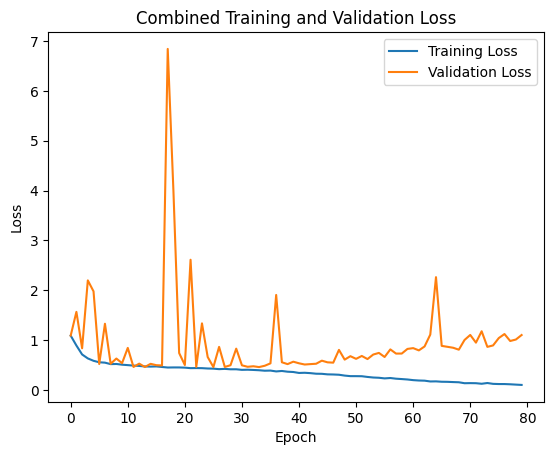

In [ ]:
threshold = 0.5

# Filter loss values below threshold
filtered_loss_values = [loss for loss in combined_loss if loss <= threshold]


# Plot combined training and validation loss
plt.plot(combined_loss, label='Training Loss')
plt.plot(combined_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Combined Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Plot combined training and validation accuracy
plt.plot(combined_accuracy, label='Training Accuracy')
plt.plot(combined_val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Combined Training and Validation Accuracy')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

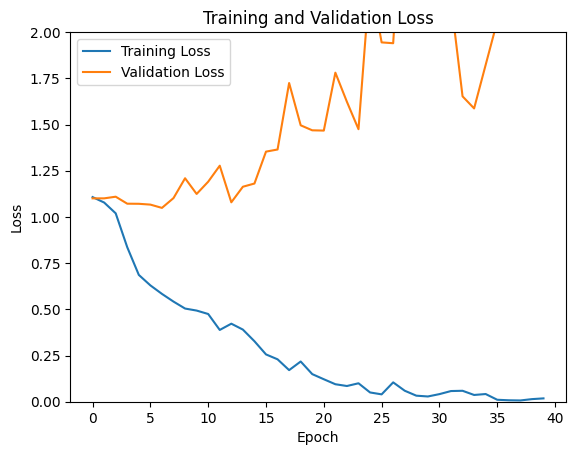

In [ ]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylim(0, 2)
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig('1.png')
plt.show()

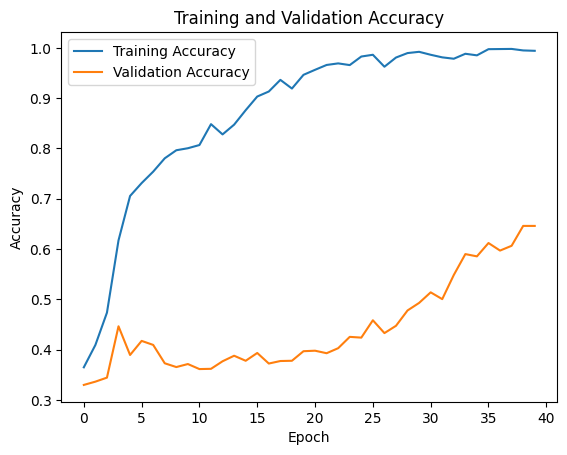

In [ ]:
# Plot training accuracy
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.savefig('2.png')
plt.show()

In [ ]:
# Plot training precision
plt.plot(history.history['precision'], label='Training Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training Precision')
plt.legend()
plt.show()

In [ ]:
# Plot training recall
plt.plot(history.history['recall'], label='Training Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training Recall')
plt.legend()
plt.show()

### predict attempt

In [ ]:
dl_model.save_weights('dl_model_weights.h5')

In [ ]:
dl_model = get_dl_model_240()
root_path = '/content/drive/MyDrive/ML project/Fusang/source_code/'
dl_model.load_weights(filepath= root_path + 'dl_model/len_240/N1G/best_weights_clas').expect_partial()


63/63 [==============================] - 3s 13ms/step


In [ ]:
X_array_test.shape

(2000, 4, 240, 1)

In [ ]:
predictions = dl_model.predict(X_array_test)
print(predictions)

63/63 [==============================] - 11s 31ms/step
[[7.77437725e-10 1.00000000e+00 1.28758240e-10]
 [7.58496972e-05 9.99913692e-01 1.05466725e-05]
 [2.09496147e-03 9.97849822e-01 5.52000638e-05]
 ...
 [3.34606171e-01 4.10901576e-01 2.54492283e-01]
 [7.77602717e-02 1.07157744e-01 8.15082014e-01]
 [4.63543497e-02 1.28113329e-01 8.25532317e-01]]


In [ ]:
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

[1 1 1 ... 1 2 2]


In [ ]:
true_labels = np.argmax(y_array_test, axis=1)
print(true_labels)

[1 1 1 ... 2 2 2]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)

Accuracy: 0.793
F1 Score: 0.7926665684145425


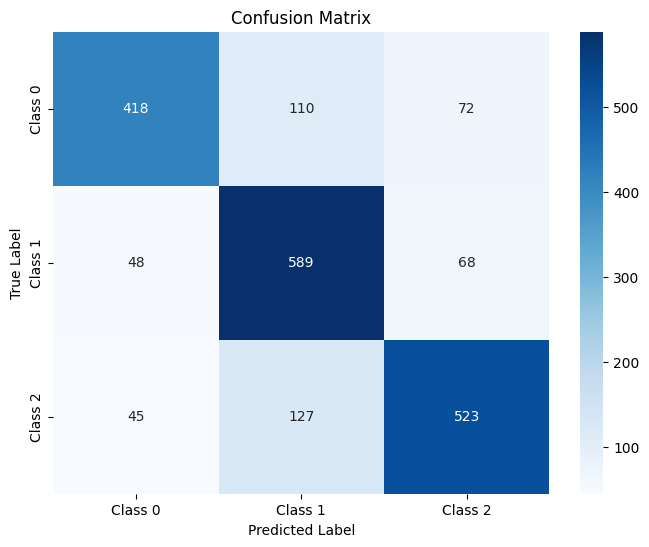

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [ ]:
dl_model.save_weights('dl_model_weights.h5')

### testing on training data

In [ ]:
k = 0
TP = 0
TN = 0
FP = 0
FN = 0

for i in tqdm(range(len(X_train))):
  msa_dir = "/content/drive/MyDrive/ML project/Fusang/source_code/example_msa/a.fas"
  save_prefix = f"dl_output_2_{i}"
  beam_size = '1'
  sequence_type = 'standard'
  branch_model = 'gamma'
  window_coverage = '1'
  taxa_name = {0: '0', 1: '1', 2: '2', 3: '3'}
  taxa_num = 4

  flag = 0
  support_format = ['.fas', '.phy', '.fasta', 'phylip']
  bio_format = ['fasta', 'phylip', 'fasta', 'phylip']

  len_of_msa = 1000

  # print(f"length of msa: ", len_of_msa)
  # print(f"taxa name: ", taxa_name)
  # print(f"taxa num: ", taxa_num)

  # if flag == 0:
  #     print('we do not support this format of msa')
  #     sys.exit(1)

  #logging.warning(taxa_num)

  start_end_list = [None, None, None]

  end = -1
  for i in range(3, 100):
      start = end + 1
      end = start + int(comb_math(i,3)) - 1
      start_end_list.append((start,end))

  id_for_taxa = [i for i in range(0, taxa_num)]
  comb_of_id = list(combinations(id_for_taxa, 4))
  comb_of_id.sort(key=lambda ele: ele[-1])
  print(len(comb_of_id))

  leave_node_id = [i for i in range(0, taxa_num)]
  leave_node_name = [chr(ord(u'\u4e00')+i) for i in range(0, taxa_num)]
  leave_node_comb_id = comb_of_id

  leave_node_comb_name = []

  dic_for_leave_node_comb_name = {}

  for ele in leave_node_comb_id:
      term = [chr(ord(u'\u4e00')+id) for id in ele]
      dic_for_leave_node_comb_name["".join(term)] = len(dic_for_leave_node_comb_name)
      leave_node_comb_name.append("".join(term))

  internal_node_name_pool = ['internal_node_' + str(i) for i in range(3, 3000)]

  # fusang_msa_dir = save_prefix + '_fusang.fas'
  # org_seq = get_numpy(fusang_msa_dir)
  # os.remove(fusang_msa_dir)

  org_seq = X_train[k]


  # print("org_seq type is:")
  # print(org_seq)

  window_number = 1


  root_path = '/content/drive/MyDrive/ML project/Fusang/source_code/'

  if len_of_msa <= 1210:
      dl_model = get_dl_model_240()
      dl_model.load_weights('dl_model_weights.h5')

      window_number = int(len_of_msa * float(window_coverage) // 240 + 1)

  elif len_of_msa > 1210:
      dl_model = get_dl_model_1200()

      dl_model.load_weights('dl_model_weights.h5')
      window_number = int(len_of_msa * float(window_coverage) // 1200 + 1)


  dl_predict = np.zeros((len(comb_of_id), 3))

  if len_of_msa > 1210:
      fill_dl_predict(window_number)
  elif len_of_msa <= 1210:
      fill_dl_predict_2(window_number)
  else:
      print('current version of fusang do not support this length of MSA')
      sys.exit(1)

  dl_predict /= window_number

  print("\n", dl_predict)

  #based on dl_predict of shape (1, 3), generate topology index
  y_pred = np.argmax(dl_predict, axis=1)
  y_true = y_train[k]
  # update TP, TN, FP, FN
  if y_pred == 0 and y_true == 0:
    TP += 1
  elif y_pred == 0 and y_true != 0:
    FP += 1
  elif y_pred != 0 and y_true == 0:
    FN += 1
  else:
    TN += 1

  #np.save('./dl_predict.npy', dl_predict)
  #dl_predict = np.load('./dl_predict.npy')

  if not os.path.exists('./dl_output/'):
      os.mkdir('./dl_output/')

  if taxa_num > 10:
      searched_tree = transform_str(gen_phylogenetic_tree_2(dl_predict, int(beam_size)), taxa_name)
  else:
      searched_tree = transform_str(gen_phylogenetic_tree(dl_predict, int(beam_size)), taxa_name)

  build_log = open('./dl_output/{}.txt'.format(save_prefix), 'a')
  build_log.write(searched_tree)
  build_log.close()


  k = k+1

print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
print(f"Accuracy: {(TP+TN)/(TP+TN+FP+FN)}")
print(f"Precision: {TP/(TP+FP)}")
print(f"Recall: {TP/(TP+FN)}")
print(f"F1 score: {2*TP/(2*TP+FP+FN)}")

In [ ]:
from tqdm import tqdm
for i in tqdm(range(len(X_train))):
  print()
  print(X_train[i])
  print()

### Training

In [ ]:
print(dl_predict.shape)

(1, 3)


### tree topo for WQFM

In [ ]:
import itertools

def calculate_probability(tree_topology, probabilities):
    prob = 1
    for pair in tree_topology:
        prob *= probabilities[pair[0]] * probabilities[pair[1]]
    return prob

def generate_tree_topologies(elements):
    return itertools.combinations(itertools.combinations(elements, 2), len(elements)//2)

def generate_output(comb, prob):
    for topology, probability in zip(comb, prob):
        output = ''
        for pair in topology:
            output += f'({pair[0]},{pair[1]}),'
        output = output[:-1]  # Remove the trailing comma
        output += f' ; {probability}'
        print(output)

comb = [(0,1,2,3)]  # single element in the list
prob = [[9.99999702e-01, 7.39642250e-08, 2.13542464e-07]]  # single element in the list

elements = comb[0]
probabilities = prob[0]

tree_topologies = generate_tree_topologies(elements)
for topology in tree_topologies:
    print(topology)


In [ ]:
from itertools import combinations

def tree_topology(quartets):
    tree_topologies = []
    for nodes in quartets:
        node_pairs = list(combinations(nodes, len(nodes) // 2))
        for pair in node_pairs[:len(node_pairs)//2]:
            remaining_nodes = list(nodes)
            for node in pair:
                remaining_nodes.remove(node)
            tree_topology = (pair, tuple(remaining_nodes))
            tree_topologies.append(tree_topology)
    return tree_topologies

list_quartet = [(0, 1, 2, 3), (0, 1, 2, 4), (1, 2, 3, 4)]
topologies = tree_topology(list_quartet)
for topology in topologies:
    print(topology)


((0, 1), (2, 3))
((0, 2), (1, 3))
((0, 3), (1, 2))
((0, 1), (2, 4))
((0, 2), (1, 4))
((0, 4), (1, 2))
((1, 2), (3, 4))
((1, 3), (2, 4))
((1, 4), (2, 3))


In [ ]:
import numpy as np

def flatten_list(list_of_arrays):
    flattened_list = []
    for array in list_of_arrays:
        if isinstance(array, np.ndarray):
            flattened_list.extend(array.flatten())
        else:
            flattened_list.append(float(array))
    return flattened_list

# Example usage


result = flatten_list(dl_predict)
print(result)


[0.999999702, 7.3964225e-08, 2.13542464e-07, 0.983438581, 0.00665196823, 0.00990937138, 0.993414193, 0.0024526745, 0.00413305021]


In [ ]:
print(dl_predict)

[[7.61078417e-01 1.54987549e-01 8.39340812e-02]
 [5.55159268e-01 7.00606279e-02 3.74780092e-01]
 [5.39546927e-01 6.93103850e-02 3.91142695e-01]
 [1.99618620e-01 2.36619148e-01 5.63762233e-01]
 [2.31661189e-01 2.98791443e-01 4.69547391e-01]
 [6.45647120e-01 1.77373552e-01 1.76979336e-01]
 [6.33922732e-01 1.90632603e-01 1.75444661e-01]
 [9.99353945e-01 4.56232369e-04 1.89843124e-04]
 [2.68177464e-01 3.41049278e-01 3.90773267e-01]
 [9.99290061e-01 4.82016860e-04 2.27911701e-04]
 [9.99232483e-01 5.14330907e-04 2.53179490e-04]
 [2.37388245e-01 3.05950527e-01 4.56661221e-01]
 [9.99922550e-01 2.49766971e-05 5.25138103e-05]
 [9.99930286e-01 1.91974395e-05 5.05096365e-05]
 [9.99851477e-01 4.44518592e-05 1.04056406e-04]
 [6.22084771e-01 1.84077515e-01 1.93837717e-01]
 [6.21508256e-01 2.03439984e-01 1.75051765e-01]
 [9.51751781e-01 4.73609273e-02 8.87271734e-04]
 [9.98681808e-01 6.84870182e-04 6.33347741e-04]
 [2.88843496e-01 3.35888427e-01 3.75268087e-01]
 [9.36624098e-01 6.03653440e-02 3.010553

In [ ]:
import numpy as np
from itertools import combinations

def flatten_list(list_of_arrays):
    flattened_list = []
    for array in list_of_arrays:
        if isinstance(array, np.ndarray):
            flattened_list.extend(array.flatten())
        else:
            flattened_list.append(float(array))
    return flattened_list

def combine_values(comb, values):
    combined_values = []
    for nodes, value in zip(comb, values):
        pairs = [(nodes[:2], nodes[2:]), value]
        combined_values.append(pairs)
    return combined_values

#comb = [(0, 1, 2, 3), (0, 1, 2, 4), (1, 2, 3, 4)]
comb = comb_of_id
# #list_of_arrays = np.array([[9.99999702e-01, 7.39642250e-08, 2.13542464e-07],
#                             [9.83438581e-01, 6.65196823e-03, 9.90937138e-03],
#                             [9.93414193e-01, 2.45267450e-03, 4.13305021e-03]])
values = flatten_list(dl_predict)

topologies = tree_topology(comb)
for (topology, value) in zip(topologies, values):
    print(f"{topology}; {value:.9f}")


((0, 1), (2, 3)); 0.761078417
((0, 2), (1, 3)); 0.154987549
((0, 3), (1, 2)); 0.083934081
((0, 1), (2, 4)); 0.555159268
((0, 2), (1, 4)); 0.070060628
((0, 4), (1, 2)); 0.374780092
((0, 1), (3, 4)); 0.539546927
((0, 3), (1, 4)); 0.069310385
((0, 4), (1, 3)); 0.391142695
((0, 2), (3, 4)); 0.199618620
((0, 3), (2, 4)); 0.236619148
((0, 4), (2, 3)); 0.563762233
((1, 2), (3, 4)); 0.231661189
((1, 3), (2, 4)); 0.298791443
((1, 4), (2, 3)); 0.469547391
((0, 1), (2, 5)); 0.645647120
((0, 2), (1, 5)); 0.177373552
((0, 5), (1, 2)); 0.176979336
((0, 1), (3, 5)); 0.633922732
((0, 3), (1, 5)); 0.190632603
((0, 5), (1, 3)); 0.175444661
((0, 1), (4, 5)); 0.999353945
((0, 4), (1, 5)); 0.000456232
((0, 5), (1, 4)); 0.000189843
((0, 2), (3, 5)); 0.268177464
((0, 3), (2, 5)); 0.341049278
((0, 5), (2, 3)); 0.390773267
((0, 2), (4, 5)); 0.999290061
((0, 4), (2, 5)); 0.000482017
((0, 5), (2, 4)); 0.000227912
((0, 3), (4, 5)); 0.999232483
((0, 4), (3, 5)); 0.000514331
((0, 5), (3, 4)); 0.000253179
((1, 2), (